In [25]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from domain_adaptation import CNNClassifier
from domain_adaptation.utils import EvalOnDomains

from utils.preprocessing import feature_normalization
from utils.plot import scatterplot

plt.style.use('science')

plt.rcParams['mathtext.fontset'] = 'custom' 
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans' 
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic' 
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold' 
plt.rcParams['font.size'] = 16 
plt.rcParams['mathtext.fontset'] = 'stix' 
plt.rcParams['font.family'] = 'STIXGeneral' 

In [3]:
num_cores = multiprocessing.cpu_count()
num_folds = 5
use_gpu = False

if use_gpu:
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
    config = tf.ConfigProto(gpu_options=gpu_options)
    config.gpu_options.allow_growth = True
else:
    config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                            inter_op_parallelism_threads=num_cores, 
                            allow_soft_placement=True,
                            device_count = {'CPU' : 1,
                                            'GPU' : 0}
                        )

session = tf.Session(config=config)
tf.keras.backend.set_session(session)

In [4]:
data = np.load('./data/ttanks_acf_0.05.npy')
d = data[:, -1]

data = np.load('./data/ttanks_raw_0.05.npy')
X = data[:, :-1]
y = data[:, -1]

Xs, ys = X[np.where(d == 0)[0], :, np.newaxis], y[np.where(d == 0)[0]]
Xtr, Xts, ytr, yts = train_test_split(Xs, ys, train_size=0.8, stratify=ys)

ytr = tf.keras.utils.to_categorical(ytr)
yts = tf.keras.utils.to_categorical(yts)

Xtargets = [X[np.where(d == domain)[0], :, np.newaxis] for domain in np.unique(d)[1:].astype(int)]
ytargets = [y[np.where(d == domain)[0]] for domain in np.unique(d)[1:].astype(int)]

In [5]:
cnn = CNNClassifier(input_shape=(1500, 1), n_classes=5)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
cback = EvalOnDomains(model=cnn.model, Xtargets=Xtargets, ytargets=ytargets)
hist_dict = cnn.fit(Xtr, ytr, batch_size=256, epochs=8, callbacks=[cback],
                    validation_data=(Xts, yts))

Train on 800 samples, validate on 200 samples
Epoch 1/8
768/800 [===========================>..] - ETA: 0s - loss: 1.2601 - acc: 0.3984Domain: 0, Acc: 0.6
Domain: 1, Acc: 0.6
Domain: 2, Acc: 0.6
Domain: 3, Acc: 0.6
Domain: 4, Acc: 0.6
Domain: 5, Acc: 0.6
Domain: 6, Acc: 0.6
Domain: 7, Acc: 0.6
Domain: 8, Acc: 0.4
800/800 [==============================] - 6s 7ms/sample - loss: 1.2381 - acc: 0.4162 - val_loss: 0.8570 - val_acc: 0.6000
Epoch 2/8
768/800 [===========================>..] - ETA: 0s - loss: 0.6249 - acc: 0.7214Domain: 0, Acc: 1.0
Domain: 1, Acc: 0.995
Domain: 2, Acc: 1.0
Domain: 3, Acc: 1.0
Domain: 4, Acc: 1.0
Domain: 5, Acc: 0.8
Domain: 6, Acc: 0.8
Domain: 7, Acc: 0.77
Domain: 8, Acc: 0.515
800/800 [==============================] - 5s 7ms/sample - loss: 0.6086 - acc: 0.7325 - val_loss: 0.2348 - val_acc: 0.9700
Epoch 3/8
768/800 [===========================>..] - ETA: 0s - loss: 0.2044 - acc: 0.9245Domain: 0, Acc: 1.0
Domain: 1, Acc: 1.0
Domain: 2, Acc: 0.805
Domain: 3, Acc

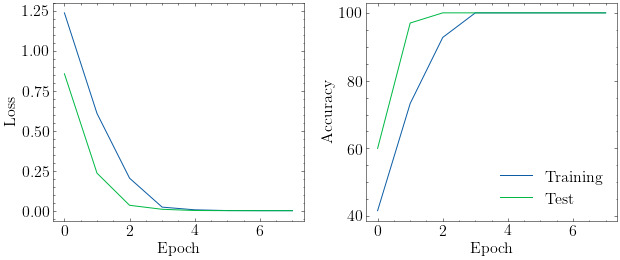

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

axes[0].plot(hist_dict.history['loss'])
axes[0].plot(hist_dict.history['val_loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

axes[1].plot(100 * np.array(hist_dict.history['acc']), label='Training')
axes[1].plot(100 * np.array(hist_dict.history['val_acc']), label='Test')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout()

plt.savefig('./Figures/Ch3/CNN_Training.pdf', transparent=True)

In [21]:
layers_outputs = [l.output for l in cnn.model.layers[1:]]
layerized_model = tf.keras.models.Model(inputs=layers[0].input, outputs=layers_outputs)
activations = layerized_model.predict(Xs)
Z = activations[6]

In [22]:
tsne = TSNE(n_components=2, init='random')
Zemb = tsne.fit_transform(Z)

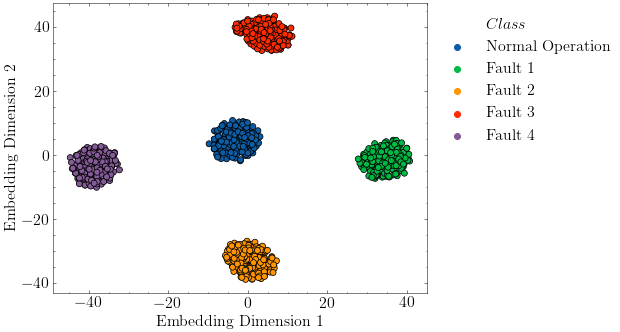

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
label_names = []
class_names = ["Normal Operation", "Fault 1", "Fault 2", "Fault 3", "Fault 4"]
for yi in ys:
    label_names.append(class_names[yi.astype(int)])
    
scatterplot(Zemb, label_names=label_names, column_names=[r"Embedding Dimension 1",
                                                         r"Embedding Dimension 2"], ax=ax)
plt.savefig('./Figures/Ch3/TTanks_CNN_Features.pdf')

/home/eduardo/repos/CrossDomainFaultDetection/utils/plot.py:31: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  if tight: plt.tight_layout()


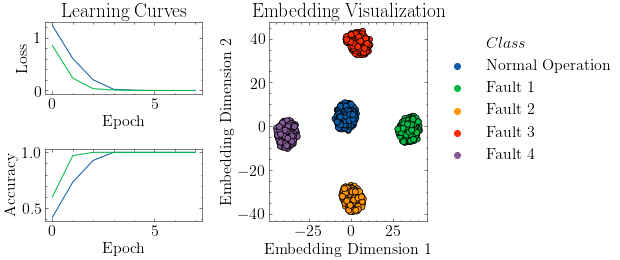

In [41]:
fig3 = plt.figure(constrained_layout=True, figsize=(9, 4))
#widths = [1, 1]
#heights = [1, 1]
# gs = fig3.add_gridspec(2, 3, width_ratios=widths, height_ratios=heights)

gs = fig3.add_gridspec(2, 2)
ax = fig3.add_subplot(gs[0, 0])
ax.plot(hist_dict.history['loss'])
ax.plot(hist_dict.history['val_loss'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Learning Curves')
ax = fig3.add_subplot(gs[1, 0])
ax.plot(hist_dict.history['acc'])
ax.plot(hist_dict.history['val_acc'])
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax = fig3.add_subplot(gs[:, 1:])
label_names = []
class_names = ["Normal Operation", "Fault 1", "Fault 2", "Fault 3", "Fault 4"]
for yi in ys:
    label_names.append(class_names[yi.astype(int)])
    
scatterplot(Zemb, label_names=label_names, column_names=[r"Embedding Dimension 1",
                                                         r"Embedding Dimension 2"], ax=ax)
ax.set_title('Embedding Visualization')
plt.tight_layout()
plt.savefig('./Figures/Ch3/CNNSummary.pdf', transparent=True)